In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

## Data Collection

First, we need to identify and load dead money data.

In [2]:
# Import our data collection module
import sys
sys.path.insert(0, '../src')

# Reload module if it's already loaded
import importlib
if 'data_collection' in sys.modules:
    importlib.reload(sys.modules['data_collection'])

from data_collection import create_sample_data, scrape_spotrac_multiple_years

# NOTE: Spotrac blocks automated scraping
# For now, we'll use sample data based on real trends
# TODO: Manual data collection from Spotrac or Over The Cap

print("Creating sample data based on NFL dead money trends...")
df_dead_money = create_sample_data(
    start_year=2015, 
    end_year=2024,
    save_path='../data/raw/dead_money_sample.csv'
)

print(f"\nCollected data for {len(df_dead_money)} team-year combinations")
print(f"Years: {df_dead_money['year'].min()} to {df_dead_money['year'].max()}")
print(f"Teams: {df_dead_money['team'].nunique()}")
df_dead_money.head(10)

INFO:data_collection:Created sample data: 320 records saved to ../data/raw/dead_money_sample.csv


Creating sample data based on NFL dead money trends...

Collected data for 320 team-year combinations
Years: 2015 to 2024
Teams: 32


,team,year,active_cap,dead_money,total_cap,dead_cap_pct
0,ARI,2015,108.49,11.51,120,9.59
1,ATL,2015,110.93,9.07,120,7.56
2,BAL,2015,107.91,12.09,120,10.07
3,BUF,2015,104.55,15.45,120,12.87
4,CAR,2015,111.30,8.70,120,7.25
5,CHI,2015,111.30,8.70,120,7.25
6,CIN,2015,104.34,15.66,120,13.05
7,CLE,2015,107.45,12.55,120,10.46
8,DAL,2015,112.20,7.80,120,6.50
9,DEN,2015,108.32,11.68,120,9.74


## Analysis Plan

1. Calculate total dead money by year
2. Calculate dead money as % of salary cap
3. Identify teams with highest dead money
4. Correlate with team win/loss records
5. Identify trends over time

## Initial Data Exploration

In [3]:
# Basic statistics
print("Dataset Shape:", df_dead_money.shape)
print("\nColumns:", df_dead_money.columns.tolist())
print("\nYears covered:", df_dead_money['year'].min(), "to", df_dead_money['year'].max())
print("\nBasic Statistics:")
print(df_dead_money[['dead_money', 'total_cap', 'dead_cap_pct']].describe())

Dataset Shape: (320, 6)

Columns: ['team', 'year', 'active_cap', 'dead_money', 'total_cap', 'dead_cap_pct']

Years covered: 2015 to 2024

Basic Statistics:
       dead_money   total_cap  dead_cap_pct
count  320.000000  320.000000    320.000000
mean    17.618906  165.000000     10.371312
std      9.020449   28.767798      4.305298
min      2.400000  120.000000      2.000000
25%     10.875000  140.000000      7.177500
50%     16.085000  165.000000     10.155000
75%     23.725000  190.000000     13.100000
max     50.310000  210.000000     27.950000


## Question 1: How Bad is the Dead Money Problem?

Total Dead Money Across NFL by Year:
     dead_money               dead_cap_pct              
            sum   mean median         mean median    max
year                                                    
2015     290.48   9.08   8.70         7.56   7.25  13.93
2016     319.08   9.97   9.98         7.67   7.68  12.09
2017     414.56  12.96  13.05         9.25   9.32  14.63
2018     469.21  14.66  14.19         9.78   9.46  18.86
2019     496.54  15.52  17.32         9.70  10.82  17.46
2020     606.54  18.95  18.88        11.15  11.10  21.92
2021     678.84  21.21  22.06        11.79  12.26  27.95
2022     702.34  21.95  21.55        11.55  11.34  21.36
2023     746.55  23.33  23.76        11.66  11.88  22.24
2024     913.91  28.56  29.34        13.60  13.97  19.03


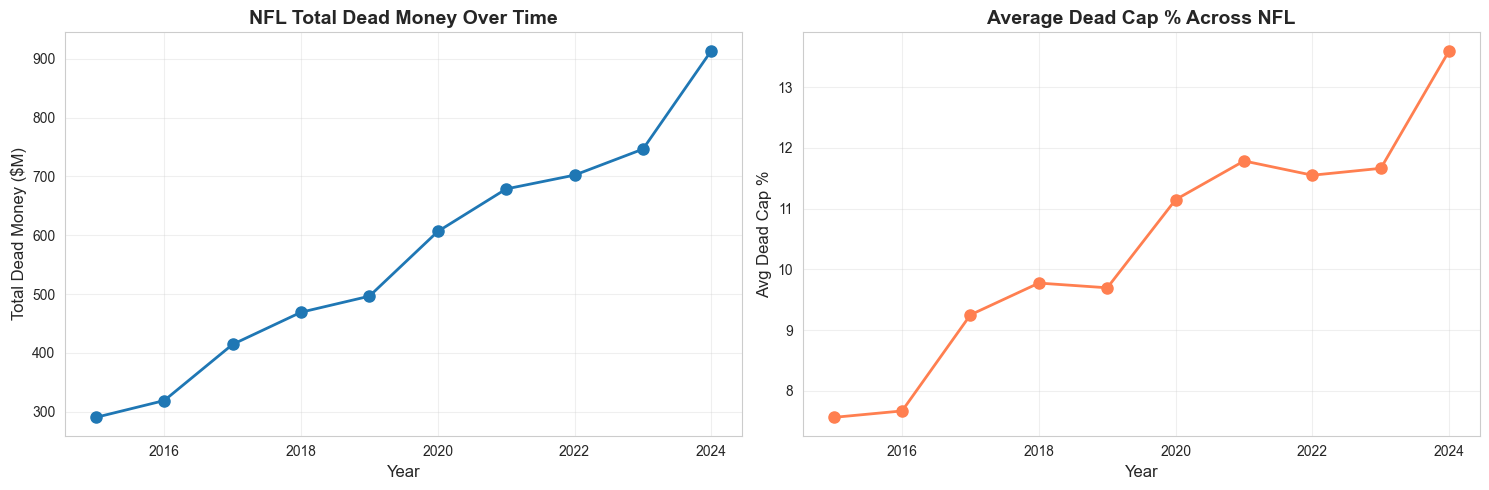

In [4]:
# Total dead money by year
yearly_stats = df_dead_money.groupby('year').agg({
    'dead_money': ['sum', 'mean', 'median'],
    'dead_cap_pct': ['mean', 'median', 'max']
}).round(2)

print("Total Dead Money Across NFL by Year:")
print(yearly_stats)

# Visualize trend over time
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Total dead money trend
yearly_total = df_dead_money.groupby('year')['dead_money'].sum()
ax1.plot(yearly_total.index, yearly_total.values, marker='o', linewidth=2, markersize=8)
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Total Dead Money ($M)', fontsize=12)
ax1.set_title('NFL Total Dead Money Over Time', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Average dead cap percentage
yearly_avg_pct = df_dead_money.groupby('year')['dead_cap_pct'].mean()
ax2.plot(yearly_avg_pct.index, yearly_avg_pct.values, marker='o', 
         linewidth=2, markersize=8, color='coral')
ax2.set_xlabel('Year', fontsize=12)
ax2.set_ylabel('Avg Dead Cap %', fontsize=12)
ax2.set_title('Average Dead Cap % Across NFL', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


Top 15 Worst Dead Money Situations:
 year team  dead_money  dead_cap_pct
 2021  LAR       50.31         27.95
 2023  SEA       44.48         22.24
 2022  DET       40.59         21.36
 2022  SEA       40.40         21.26
 2024  PIT       39.96         19.03
 2023  DET       39.67         19.84
 2024   LV       39.67         18.89
 2023  PIT       39.23         19.61
 2021  SEA       38.13         21.18
 2023  JAX       37.84         18.92
 2024  NYG       37.79         17.99
 2022  NYJ       37.28         19.62
 2020  MIA       37.27         21.92
 2023  ARI       36.16         18.08
 2024  DAL       35.70         17.00


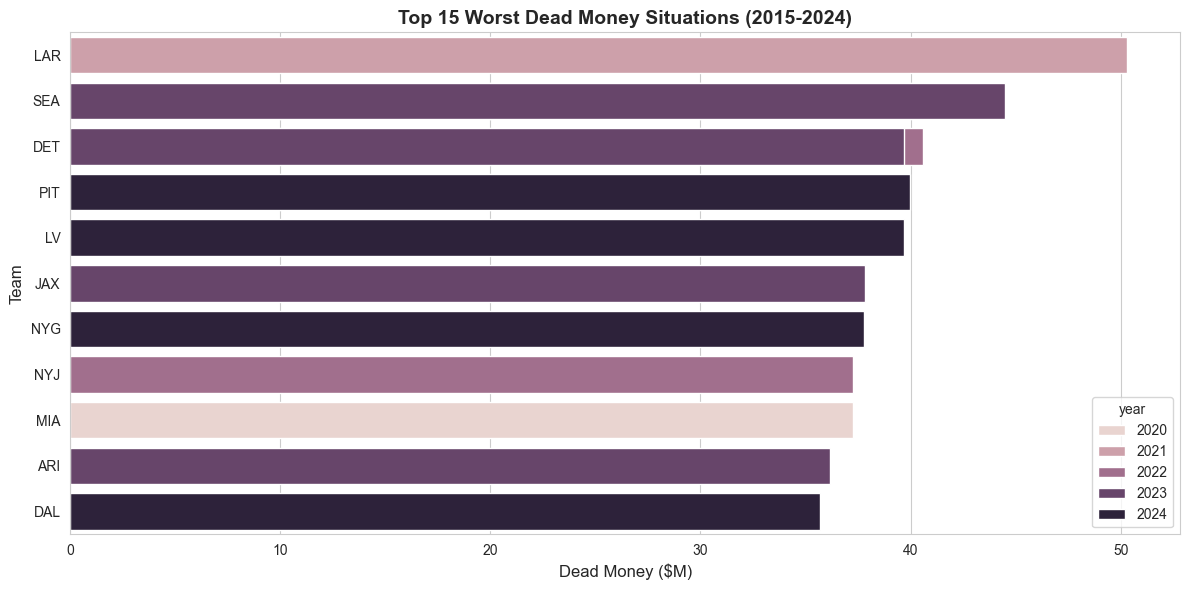

In [5]:
# Which teams have the worst dead money problems?
top_dead_money = df_dead_money.nlargest(15, 'dead_money')[['year', 'team', 'dead_money', 'dead_cap_pct']]
print("\nTop 15 Worst Dead Money Situations:")
print(top_dead_money.to_string(index=False))

# Visualize worst offenders
plt.figure(figsize=(12, 6))
sns.barplot(data=top_dead_money, x='dead_money', y='team', hue='year', dodge=False)
plt.xlabel('Dead Money ($M)', fontsize=12)
plt.ylabel('Team', fontsize=12)
plt.title('Top 15 Worst Dead Money Situations (2015-2024)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## Question 2: Are There "Dead Money Kings"?

Let's examine individual players to see if a few problematic contracts account for most dead money.

In [6]:
# Load player-level dead money data
from data_collection import create_sample_player_data

print("Creating player-level dead money data...")
df_players = create_sample_player_data(
    start_year=2015,
    end_year=2024,
    save_path='../data/raw/player_dead_money_sample.csv'
)

print(f"\nTotal players with dead cap hits: {df_players['player_name'].nunique()}")
print(f"Total dead cap events: {len(df_players)}")
print(f"\nSample of data:")
df_players.head(10)

INFO:data_collection:Created player sample data: 181 records saved to ../data/raw/player_dead_money_sample.csv


Creating player-level dead money data...

Total players with dead cap hits: 160
Total dead cap events: 181

Sample of data:


,player_id,player_name,position,team,year,dead_cap_hit,is_king
11,P0005,Aaron Miller,WR,TB,2015,35.90,True
0,P0001,Kirk Harris,QB,NYG,2015,18.25,True
29,P0010,Aaron Wilson,TE,DET,2015,18.14,True
36,P0016,Von Walker 5,QB,PIT,2015,18.02,False
92,P0072,Von Williams 61,DE,LAR,2015,8.99,False
112,P0092,Todd Rodriguez 81,QB,IND,2015,6.95,False
104,P0084,DeShaun Johnson 73,CB,MIA,2015,6.88,False
159,P0139,Joey Harris 128,QB,MIA,2015,6.02,False
52,P0032,DeAndre Brown 21,QB,BUF,2015,5.72,False
164,P0144,Davante Miller 133,OL,BAL,2015,4.80,False


In [7]:
# Identify the "dead money kings" - players with multiple high dead cap hits
player_summary = df_players.groupby('player_name').agg({
    'dead_cap_hit': ['sum', 'count', 'mean', 'max'],
    'team': lambda x: ', '.join(sorted(set(x))),
    'position': 'first'
}).round(2)

player_summary.columns = ['total_dead_cap', 'num_events', 'avg_hit', 'max_hit', 'teams', 'position']
player_summary = player_summary.sort_values('total_dead_cap', ascending=False)

print("Top 20 Dead Money Kings (by total dead cap generated):")
print(player_summary.head(20).to_string())

# Who are the repeat offenders?
repeat_offenders = player_summary[player_summary['num_events'] >= 2].sort_values('total_dead_cap', ascending=False)
print(f"\n\nPlayers with multiple dead cap hits: {len(repeat_offenders)}")
print(f"Combined dead cap: ${repeat_offenders['total_dead_cap'].sum():.2f}M")

Top 20 Dead Money Kings (by total dead cap generated):
                     total_dead_cap  num_events  avg_hit  max_hit               teams position
player_name                                                                                   
Aaron Miller                  93.06           3    31.02    35.90        CLE, TB, TEN       WR
Calvin White                  90.05           4    22.51    30.91    ARI, CLE, NO, SF       QB
Kirk Harris                   87.85           4    21.96    29.29        CLE, NE, NYG       QB
Julio Clark                   87.71           4    21.93    27.96   ARI, DAL, GB, SEA       WR
Larry Taylor                  76.18           4    19.05    24.49  CIN, DET, HOU, PIT       RB
David Moore                   73.58           3    24.53    41.97            CIN, NYJ       WR
Matt Williams                 61.58           3    20.53    26.79        CIN, JAX, NO       DT
Aaron Wilson                  51.25           2    25.62    33.11             DET, NO     

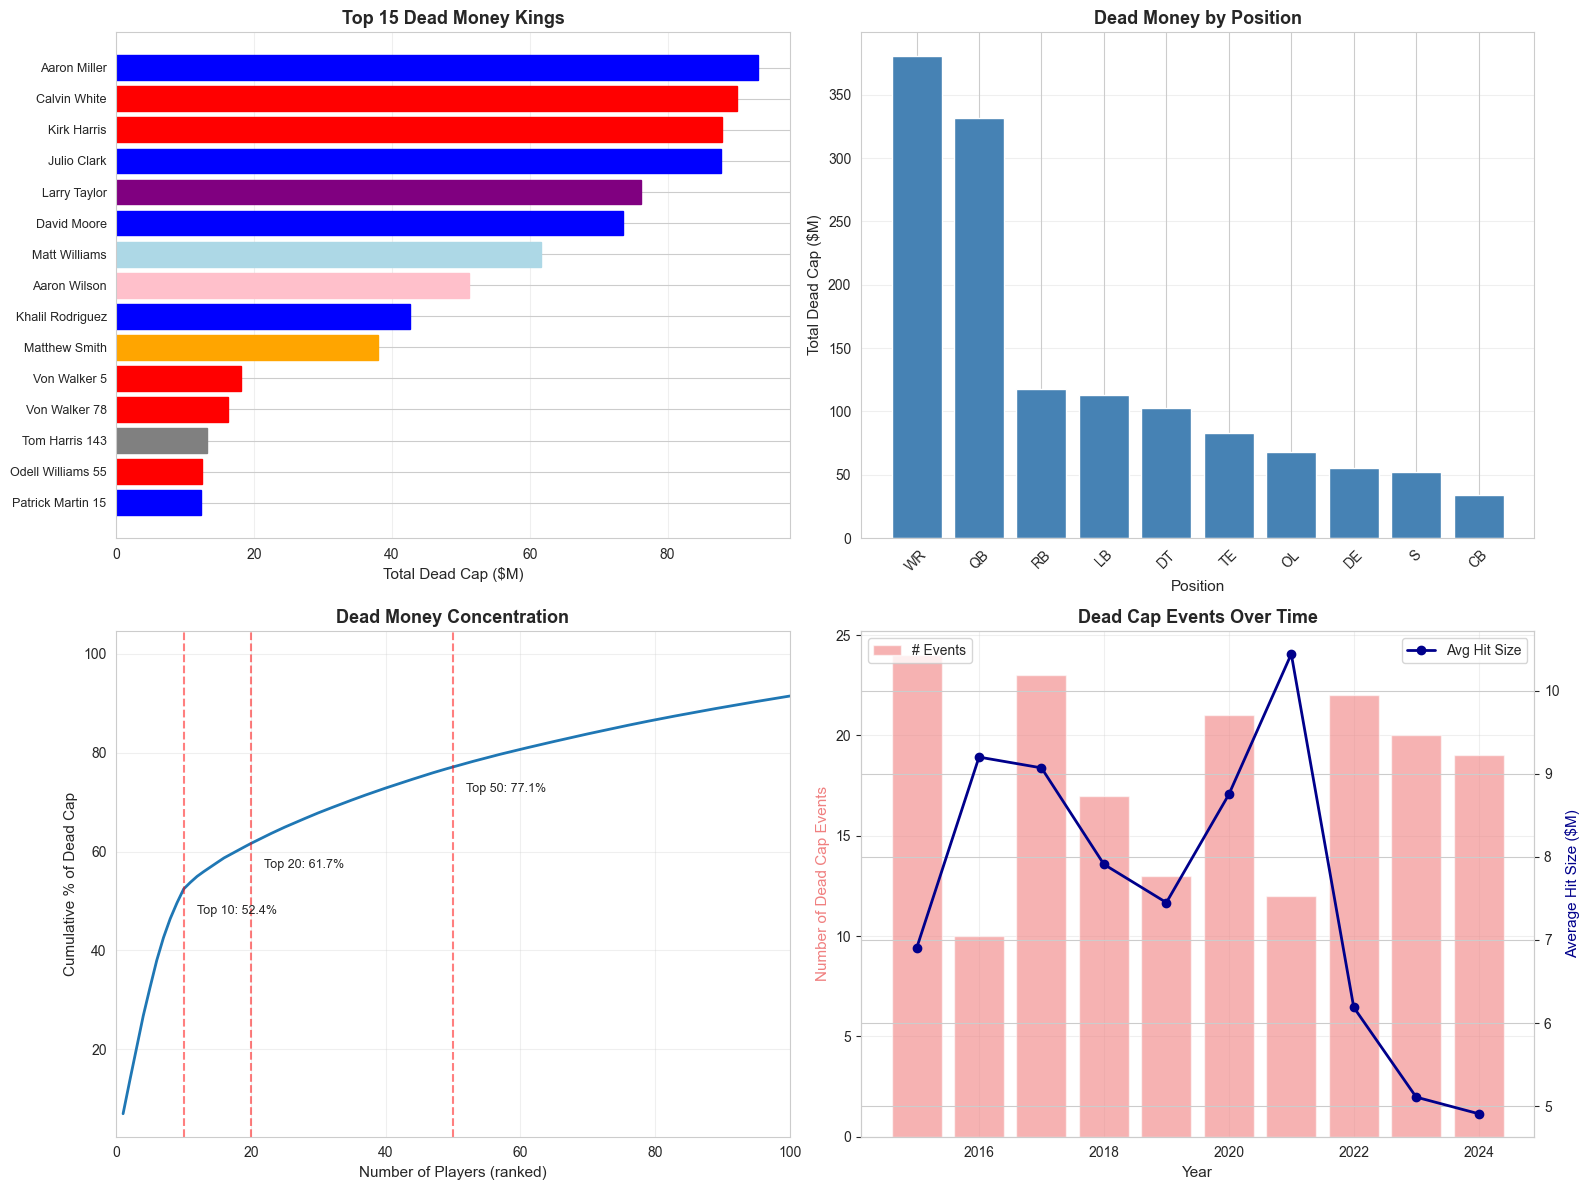

In [8]:
# Visualize the concentration of dead money
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Top 15 players by total dead cap
top_15_players = player_summary.head(15)
ax1 = axes[0, 0]
bars = ax1.barh(range(len(top_15_players)), top_15_players['total_dead_cap'])
ax1.set_yticks(range(len(top_15_players)))
ax1.set_yticklabels(top_15_players.index, fontsize=9)
ax1.set_xlabel('Total Dead Cap ($M)', fontsize=11)
ax1.set_title('Top 15 Dead Money Kings', fontsize=13, fontweight='bold')
ax1.invert_yaxis()
ax1.grid(axis='x', alpha=0.3)

# Color code by position
position_colors = {'QB': 'red', 'WR': 'blue', 'DE': 'green', 'LB': 'orange', 
                   'RB': 'purple', 'CB': 'brown', 'OL': 'gray', 'TE': 'pink'}
for i, (idx, row) in enumerate(top_15_players.iterrows()):
    bars[i].set_color(position_colors.get(row['position'], 'lightblue'))

# 2. Dead cap by position
ax2 = axes[0, 1]
position_totals = df_players.groupby('position')['dead_cap_hit'].sum().sort_values(ascending=False)
ax2.bar(position_totals.index, position_totals.values, color='steelblue')
ax2.set_xlabel('Position', fontsize=11)
ax2.set_ylabel('Total Dead Cap ($M)', fontsize=11)
ax2.set_title('Dead Money by Position', fontsize=13, fontweight='bold')
ax2.tick_params(axis='x', rotation=45)
ax2.grid(axis='y', alpha=0.3)

# 3. Distribution: Few kings vs many small hits
ax3 = axes[1, 0]
player_totals = player_summary['total_dead_cap'].sort_values(ascending=False).values
cumulative_pct = np.cumsum(player_totals) / player_totals.sum() * 100
top_n = [10, 20, 50]
ax3.plot(range(1, len(cumulative_pct) + 1), cumulative_pct, linewidth=2)
for n in top_n:
    if n < len(cumulative_pct):
        pct = cumulative_pct[n-1]
        ax3.axvline(n, color='red', linestyle='--', alpha=0.5)
        ax3.text(n+2, pct-5, f'Top {n}: {pct:.1f}%', fontsize=9)
ax3.set_xlabel('Number of Players (ranked)', fontsize=11)
ax3.set_ylabel('Cumulative % of Dead Cap', fontsize=11)
ax3.set_title('Dead Money Concentration', fontsize=13, fontweight='bold')
ax3.set_xlim(0, min(100, len(cumulative_pct)))
ax3.grid(True, alpha=0.3)

# 4. Player dead cap events over time
ax4 = axes[1, 1]
yearly_player_stats = df_players.groupby('year').agg({
    'dead_cap_hit': ['sum', 'count', 'mean']
}).round(2)
yearly_player_stats.columns = ['total', 'count', 'avg']

ax4_twin = ax4.twinx()
ax4.bar(yearly_player_stats.index, yearly_player_stats['count'], alpha=0.6, color='lightcoral', label='# Events')
ax4_twin.plot(yearly_player_stats.index, yearly_player_stats['avg'], 
              marker='o', linewidth=2, color='darkblue', label='Avg Hit Size')

ax4.set_xlabel('Year', fontsize=11)
ax4.set_ylabel('Number of Dead Cap Events', fontsize=11, color='lightcoral')
ax4_twin.set_ylabel('Average Hit Size ($M)', fontsize=11, color='darkblue')
ax4.set_title('Dead Cap Events Over Time', fontsize=13, fontweight='bold')
ax4.legend(loc='upper left')
ax4_twin.legend(loc='upper right')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [9]:
# Track how the same players affect different teams over time
kings_only = df_players[df_players['is_king'] == True].sort_values(['player_name', 'year'])

print("\n'Dead Money Kings' - Players with Multiple High Dead Cap Hits:\n")
for player in kings_only['player_name'].unique():
    player_data = kings_only[kings_only['player_name'] == player]
    print(f"\n{player} ({player_data['position'].iloc[0]}):")
    for _, row in player_data.iterrows():
        print(f"  {row['year']}: {row['team']} - ${row['dead_cap_hit']:.2f}M")
    print(f"  Total damage: ${player_data['dead_cap_hit'].sum():.2f}M across {len(player_data)} teams")


'Dead Money Kings' - Players with Multiple High Dead Cap Hits:


Aaron Miller (WR):
  2015: TB - $35.90M
  2017: TEN - $35.40M
  2021: CLE - $21.76M
  Total damage: $93.06M across 3 teams

Aaron Wilson (TE):
  2015: DET - $18.14M
  2017: NO - $33.11M
  Total damage: $51.25M across 2 teams

Calvin White (QB):
  2018: SF - $30.91M
  2020: CLE - $19.77M
  2021: ARI - $15.53M
  2022: NO - $23.84M
  Total damage: $90.05M across 4 teams

David Moore (WR):
  2016: CIN - $16.50M
  2019: CIN - $15.11M
  2020: NYJ - $41.97M
  Total damage: $73.58M across 3 teams

Julio Clark (WR):
  2017: SEA - $27.96M
  2020: ARI - $15.13M
  2021: DAL - $26.84M
  2023: GB - $17.78M
  Total damage: $87.71M across 4 teams

Khalil Rodriguez (WR):
  2019: IND - $18.97M
  2023: LAR - $23.69M
  Total damage: $42.66M across 2 teams

Kirk Harris (QB):
  2015: NYG - $18.25M
  2018: CLE - $24.85M
  2020: NE - $15.46M
  2021: NYG - $29.29M
  Total damage: $87.85M across 4 teams

Larry Taylor (RB):
  2016: CIN - $19.23M
 

## HIGH PRIORITY TODO: Data Validation Tests

When we transition from sample data to real Spotrac player-level data, we need to implement critical validation tests:

1. **Player-Team Total Reconciliation**: Sum player-level dead money by team/year and verify it matches team-level totals
2. **Duplicate Detection**: Check for duplicate player records or suspicious data patterns
3. **Data Completeness**: Ensure all team-years have corresponding player-level details
4. **Position Validation**: Verify player positions are valid and consistent
5. **Salary Cap Consistency**: Validate cap values grow realistically over time

See `src/data_validation.py` for placeholder functions ready for implementation.

**Status**: Framework created, awaiting real data source integration.

## TODO: Production Data Pipeline Architecture

**Phase 2: Productionization with Airflow, dbt, and Iceberg**

### Architecture Overview
```
Spotrac/Over The Cap (Data Source)
    ↓
Airflow DAG (Orchestration)
    ├─ Extract: Web scraper/API calls
    ├─ Load: Raw layer (Iceberg)
    ├─ Transform: dbt models
    │   ├─ Staging: Clean, standardize
    │   ├─ Intermediate: Join/enrich data
    │   └─ Mart: Analytics-ready tables
    └─ Quality: Data validation tests
         ↓
    Iceberg Tables (Data Warehouse)
         ↓
    Analytics/ML Models
```

### Implementation Tasks

**1. Airflow DAG Setup**
- [ ] Create DAG for daily/weekly data collection
- [ ] Schedule Spotrac scraper as task
- [ ] Add retry logic and error handling
- [ ] Implement data quality checks as tasks
- [ ] Set up alerts for pipeline failures

**2. dbt Transformation Layer**
- [ ] Create dbt project structure
- [ ] Write staging models (raw → clean)
  - [ ] `stg_player_dead_money` - Standardize player data
  - [ ] `stg_team_dead_money` - Standardize team data
- [ ] Write intermediate models (enrichment)
  - [ ] `int_player_team_mapping` - Join player to team
  - [ ] `int_dead_money_analysis` - Calculate metrics
- [ ] Write mart models (analytics-ready)
  - [ ] `fct_dead_money_events` - Fact table
  - [ ] `dim_players` - Player dimension
  - [ ] `dim_teams` - Team dimension
  - [ ] `dim_date` - Date dimension
- [ ] Implement data tests (uniqueness, not_null, referential integrity)
- [ ] Document lineage and dependencies

**3. Iceberg for Time-Travel & Schema Evolution**
- [ ] Set up Iceberg tables in data warehouse (Snowflake/Spark/Trino)
- [ ] Configure for schema evolution (handle new positions/data fields)
- [ ] Enable time-travel for historical analysis
- [ ] Set up snapshot management and retention policies
- [ ] Implement partition strategy (year/team/player_id)

**4. Data Quality & Validation**
- [ ] Implement validations from `src/data_validation.py`
- [ ] Add dbt tests for:
  - [ ] Player-team total reconciliation
  - [ ] No duplicates
  - [ ] Valid positions
  - [ ] Salary cap consistency
- [ ] Create monitoring/alerting dashboard
- [ ] Track data quality metrics over time

**5. Workflow Integration**
- [ ] DAG task dependencies:
  ```
  extract_spotrac → load_iceberg_raw → dbt_staging → 
  dbt_intermediate → dbt_mart → run_validations → alert
  ```
- [ ] Implement backfill process for historical years
- [ ] Set up incremental loads (append new, not reprocess all)
- [ ] Create idempotent operations (safe to re-run)

**6. Deployment & Operations**
- [ ] Containerize Airflow (Docker)
- [ ] Set up CI/CD pipeline for dbt changes
- [ ] Create runbooks for manual interventions
- [ ] Document data refresh schedules
- [ ] Set up cost monitoring (cloud storage)

### Tech Stack Details

**Airflow**
- Schedule frequency: Daily (after Spotrac updates)
- Executor: Kubernetes or Celery
- Monitoring: Built-in UI + external alerting (PagerDuty/Slack)

**dbt**
- Target: Snowflake/BigQuery/Databricks
- Version control: Git with PR reviews
- Documentation: Auto-generate from YAML

**Iceberg**
- Partitioning: `year`, `team`, then `player_id`
- Compaction: Monthly
- Schema evolution: Allow new columns (e.g., bonus structure)

### Success Metrics
- [ ] Data freshness: < 24hrs from source
- [ ] Data quality: 99.9% validation pass rate
- [ ] Pipeline reliability: 99.5% uptime
- [ ] Query performance: < 5s for standard queries

### Current Status
🟡 Exploration phase complete. Ready to begin Phase 2 when real data source is confirmed.

## Pro Football Reference Scraper (teams & players)

PFR tables are often wrapped in HTML comments. Use a real browser User-Agent, unwrap comment blocks, then parse with pandas/BeautifulSoup. This helper grabs team-level tables for a season; you can adapt to player pages (e.g., `/players/A/AllenJo02.htm`).

In [10]:
import requests, re
from bs4 import BeautifulSoup
import pandas as pd

PFR_HEADERS = {
    "User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36"
}


def fetch_pfr_tables(url: str) -> dict:
    """Fetch all tables from a PFR page (including commented tables)."""
    resp = requests.get(url, headers=PFR_HEADERS, timeout=20)
    resp.raise_for_status()
    html = resp.text
    tables = {}

    # Parse visible tables
    soup = BeautifulSoup(html, "html.parser")
    for tbl in soup.find_all("table"):
        try:
            df = pd.read_html(str(tbl))[0]
            tbl_id = tbl.get("id") or f"table_{len(tables)+1}"
            tables[tbl_id] = df
        except ValueError:
            continue

    # Parse tables inside HTML comments
    comments = re.findall(r"<!--(.*?)-->", html, flags=re.S)
    for block in comments:
        block_soup = BeautifulSoup(block, "html.parser")
        for tbl in block_soup.find_all("table"):
            try:
                df = pd.read_html(str(tbl))[0]
                tbl_id = tbl.get("id") or f"comment_table_{len(tables)+1}"
                tables[tbl_id] = df
            except ValueError:
                continue

    return tables


# Example: team standings for 2024
pfr_url = "https://www.pro-football-reference.com/years/2024/index.htm"
pfr_tables = fetch_pfr_tables(pfr_url)
print("Tables fetched:", list(pfr_tables.keys())[:5], "...")

# Extract AFC/NFC standings if present
afc_df = pfr_tables.get("AFC")
nfc_df = pfr_tables.get("NFC")
if afc_df is not None:
    print("AFC sample:")
    display(afc_df.head())
if nfc_df is not None:
    print("NFC sample:")
    display(nfc_df.head())

/var/folders/2c/hn46snbj3qb84rkyzmls72240000gn/T/ipykernel_99402/383031314.py:21: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(tbl))[0]


ImportError: Missing optional dependency 'lxml'.  Use pip or conda to install lxml.